# Autoencoder:Grayscale to color image

https://www.kaggle.com/code/theblackmamba31/autoencoder-grayscale-to-color-image

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

# defining the size of the image
SIZE = 256
N = 500

color_img = []
path = os.path.join('..', 'data', 'train', 'opt')
files = os.listdir(path)
files = sorted_alphanumeric(files)
for file in tqdm(files[:N]):
    img = cv2.imread(os.path.join(path, file),1)
    # open cv reads images in BGR format so we have to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    color_img.append(img_to_array(img))

gray_img = []
path = os.path.join('..', 'data', 'train', 'sar')
files = os.listdir(path)
files = sorted_alphanumeric(files)
for file in tqdm(files[:N]):
    img = cv2.imread(os.path.join(path, file),1)

    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    gray_img.append(img_to_array(img))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 187.59it/s]


In [3]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image')
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ')
    plt.imshow(grayscale)
   
    plt.show()

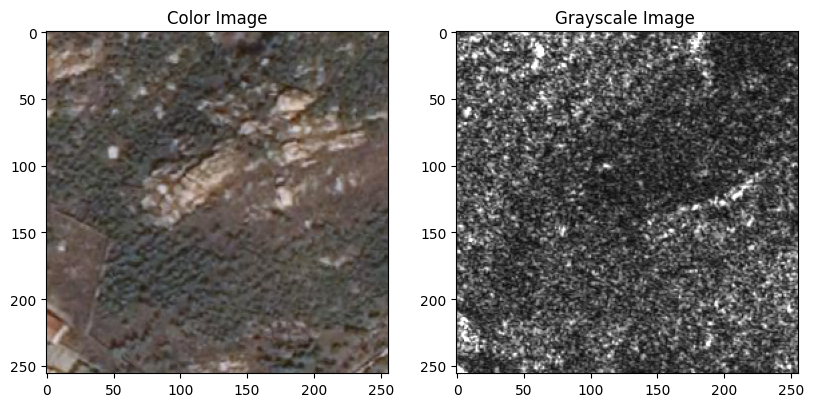

In [4]:
plot_images(color_img[0],gray_img[0])

In [5]:
train_gray_image = gray_img[:450]
train_color_image = color_img[:450]

test_gray_image = gray_img[450:]
test_color_image = color_img[450:]

# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (450, 256, 256, 3)
Test color image shape (50, 256, 256, 3)


In [6]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [7]:
def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [8]:
model = model()
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 128, 128, 128)     │           3,584 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_1 (Sequential)     │ (None, 64, 64, 128)       │         147,584 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_2 (Sequential)     │ (None, 32, 32, 256)       │         296,192 │ sequential_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_3 (Sequential)     │ (None, 16, 16, 512)       │       1,182,208 │ sequential_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_4 (Sequential)     │ (None, 8, 8, 512)         │       2,361,856 │ sequential_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_5 (Sequential)     │ (None, 16, 16, 512)       │       2,359,808 │ sequential_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 16, 16, 1024)      │               0 │ sequential_5[0][0],        │
│                               │                           │                 │ sequential_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_6 (Sequential)     │ (None, 32, 32, 256)       │       2,359,552 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 32, 32, 512)       │               0 │ sequential_6[0][0],        │
│                               │                           │                 │ sequential_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_7 (Sequential)     │ (None, 64, 64, 128)       │         589,952 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 64, 64, 256)       │               0 │ sequential_7[0][0],        │
│                               │                           │                 │ sequential_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_8 (Sequential)     │ (None, 128, 128, 128)     │         295,040 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 128, 128, 256)     │               0 │ sequential_8[0][0],        │
│                               │                           │                 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_9 (Sequential)     │ (None, 256, 256, 3)       │           6,915 │ concatenate_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 9,602,766 (36.63 MB)

 Trainable params: 9,600,206 (36.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [9]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs=50, batch_size=50)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - acc: 0.7289 - loss: 0.3914  
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - acc: 0.4241 - loss: 0.1984
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - acc: 0.3912 - loss: 0.1862
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - acc: 0.3998 - loss: 0.1796
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - acc: 0.4252 - loss: 0.1714
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - acc: 0.4324 - loss: 0.1678
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - acc: 0.5053 - loss: 0.1621
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - acc: 0.4864 - loss: 0.1577
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - acc: 0.5233 - loss: 0.1497
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - acc: 0.5371 - loss: 0.1497
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - acc: 0.5272 - loss: 0.1566
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - acc: 0.5533 - loss: 0.1486
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - acc: 0.5139 - loss: 

In [10]:
model.evaluate(test_gray_image,test_color_image)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - acc: 0.7435 - loss: 0.1329


[0.1317879557609558, 0.7582238912582397]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


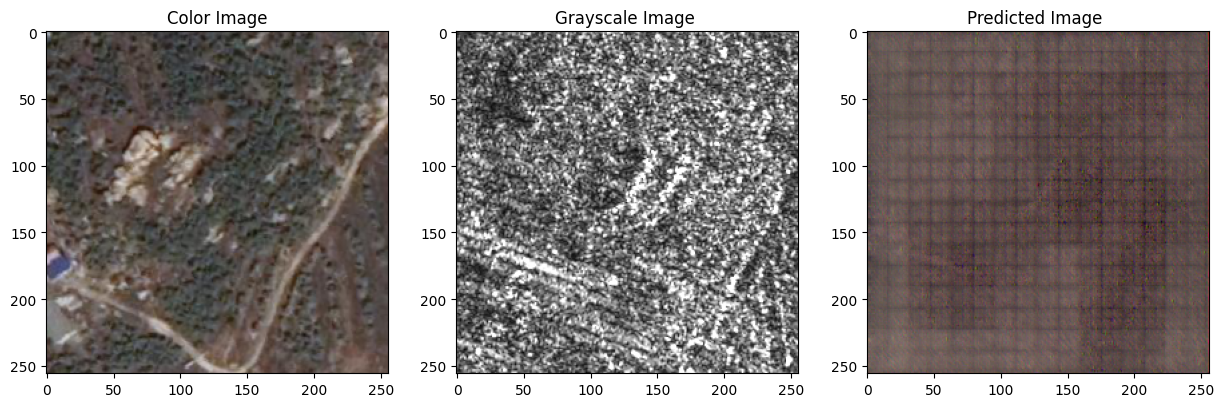

In [11]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image')
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ')
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ')
    plt.imshow(predicted)
   
    plt.show()

i = 0
predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
plot_images(test_color_image[i],test_gray_image[i],predicted)

## Evaluation

### 1. Mean Squared Error (MSE)

In [12]:
def mse(image_true, image_pred):
    return np.mean((image_true - image_pred) ** 2)
mse(test_color_image[i], predicted)

np.float32(0.01334693)

### 2. Peak Signal-to-Noise Ratio (PSNR)

In [13]:
def psnr(image_true, image_pred):
    return cv2.PSNR(image_true, image_pred)
psnr(test_color_image[i], predicted)

66.87698971421725

### 3. Structural Similarity Index (SSIM)

In [14]:
from skimage.metrics import structural_similarity as ssim
def ssim_score(image_true, image_pred):
    return ssim(image_true, image_pred, win_size=3, channel_axis=-1, data_range=1.0)
ssim_score(test_color_image[i], predicted)

np.float32(0.3066893)

### 4. Perceptual Loss (VGG Loss)

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

def perceptual_loss(y_true, y_pred):
    # Load pre-trained VGG16
    vgg = VGG16(include_top=False, weights="imagenet")
    
    # Create a feature extractor model
    model = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)
    
    # Ensure input has batch dimension
    y_true = tf.expand_dims(y_true, axis=0)  # Add batch dimension
    y_pred = tf.expand_dims(y_pred, axis=0)  # Add batch dimension

    return tf.reduce_mean(tf.square(model(y_true) - model(y_pred)))

tensor_img_1 = tf.convert_to_tensor(test_color_image[i], dtype=tf.float32)  # Ensure correct dtype
tensor_img_ = tf.convert_to_tensor(predicted, dtype=tf.float32)
perceptual_loss(tensor_img_1, tensor_img_)

<tf.Tensor: shape=(), dtype=float32, numpy=33.99135971069336>

## Saving the model

In [16]:
model.save('../models/Autoencoders-colorization.keras')